## Deep Feature Interpolation

Implentation of the [Deep Feature Interpolation](https://arxiv.org/abs/1611.05507) method on PyTorch for [ADNI](https://ida.loni.usc.edu/login.jsp?project=ADNI#) dataset of MRI images for Alzheimer-related study. The dataset is available by request.

In this notebook, we investigate how Deep Feature Interpolation (DFI) method performs for the task of MRI images manipulation, such as person's age change and Alzheimer-related features change.

In [598]:
import os
from time import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.models import vgg16
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.models import vgg16, vgg16_bn
from sklearn.neighbors import NearestNeighbors, DistanceMetric
from skimage import img_as_float
from skimage.transform import resize
from tqdm import tqdm, tqdm_notebook
import numpy as np
import pandas as pd
import mahotas as mh
import matplotlib.pyplot as plt
%matplotlib inline

#### Auxiliary functions

In [577]:
def get_mask(**kwargs):
    mask = np.ones(n_samples, dtype=np.bool)
    for h in kwargs:
        if isinstance(kwargs[h], list):
            mask &= np.in1d(labels.iloc[:, header.index(h)], kwargs[h])
        else:
            mask &= labels.iloc[:, header.index(h)] == kwargs[h]
    return mask

def to_gpu(obj):
    if torch.cuda.is_available():
        return obj.cuda()
    return obj

def to_cpu(obj):
    if torch.cuda.is_available():
        return obj.cpu()
    return obj

def image_to_tensor(image):
    return to_gpu(torch.FloatTensor(np.float32(np.array(image))))

def channel_first(ar):
    # ar can be an image (H, W, C) or an array of images (N, H, W, C)
    if isinstance(ar, np.ndarray):
        if len(ar.shape) == 3:
            return np.rollaxis(ar, 2, 0)
        elif len(ar.shape) == 4:
            return np.rollaxis(ar, 3, 1)
    else:    # assuming torch types
        if len(ar.shape) == 3:
            return ar.permute(2, 0, 1)
        elif len(ar.shape) == 4:
            return ar.permute(0, 3, 1, 2)

def channel_last(ar):
    # ar can be an image (C, H, W) or an array of images (N, C, H, W)
    if isinstance(ar, np.ndarray):
        if len(ar.shape) == 3:
            return np.rollaxis(ar, 0, 3)
        elif len(ar.shape) == 4:
            return np.rollaxis(ar, 1, 4)
    else:    # assuming torch types
        if len(ar.shape) == 3:
            return ar.permute(1, 2, 0)
        elif len(ar.shape) == 4:
            return ar.permute(0, 2, 3, 1)

def normalize(ar, eps=1e-15):
    return (ar - ar.min()) / (ar.max() - ar.min() + eps) 

### Dataset loading functions and classes

In [74]:
input_size = 128

Loading labels indices, which were not used for the encoder training.

In [493]:
all_valid_idx = np.load('../model/DFI_enc_all_valid_idx.npy')
all_valid_idx

array([2390, 2774,  122, ..., 2243, 2746,  942])

In [781]:
class mri_data(Dataset):
    def __init__(self, 
                 folder='../../data/bids_slices', 
                 metadata='../../data/matched_saved_exp.csv', 
                 columns=['anat_ras', 'AGEreal', 'DX', 'ADAS13', 'FAQ', 'PTRACCAT', 'PTETHCAT', 'PTEDUCAT'],
                 convert_to_cat=['PTRACCAT', 'PTETHCAT'],
                 resize_shape=(128, 128),
                 DX_dict={'CN': 0,'MCI': 1,'Dementia': 2},
                 age_groups=[-np.inf, 66.27000122, 72.54666697, 78.82333272, 85.09999847, np.inf], 
                 adas_groups=[-np.inf, 3.33  , 16.2035, 29.077 , 41.9505, np.inf],
                 faq_groups=[-np.inf, 6., 12., 18., 24., np.inf],
                 PTEDUCAT_thr=12,
                 transform=None):
        
        self.meta = pd.read_csv(metadata)[['id']+columns]
        self.meta = self.meta.iloc[all_valid_idx]
        self.meta = self.meta.reset_index()
        self.meta = self.meta.replace({"DX": {'CN': 0, 'MCI': 1, 'Dementia': 2}})
        if age_groups is not None:
            self.meta.AGEreal = np.digitize(self.meta.AGEreal, age_groups)
        if adas_groups is not None:
            self.meta.ADAS13 = np.digitize(self.meta.ADAS13, adas_groups)
        if faq_groups is not None:
            self.meta.FAQ = np.digitize(self.meta.FAQ, faq_groups)
        self.age_groups = age_groups
        self.adas_groups = adas_groups
        self.faq_groups = faq_groups
        if 'PTEDUCAT' in columns:
            self.meta.PTEDUCAT = (self.meta.PTEDUCAT > PTEDUCAT_thr).astype(int)
        self.categories = []    # contains mappings "code -> feature value (string)"
        for col in convert_to_cat:
            cat_accessor = self.meta[col].astype('category').cat
            self.categories.append(cat_accessor.categories)
            self.meta[col] = cat_accessor.codes
        
        self.folder = folder
        self.resize_shape = resize_shape
        self.DX_dict = DX_dict
        self.transform = transform
        
    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        true_path = self.folder + '/' + self.meta.anat_ras[idx][54:-7] + '.png'
        img = plt.imread(fname=true_path)

        attr = self.meta.iloc[idx].drop(['anat_ras', 'id'])

        if not self.resize_shape is None:
            img = resize(img, output_shape=self.resize_shape, mode='reflect', preserve_range=True)

        img = normalize(img_as_float(img))

        if self.transform is not None:
            img = self.transform(img)

        return {'input': img, 'attr': attr}

In [782]:
data = mri_data(transform=transforms.Compose([transforms.ToTensor()]),
                resize_shape=(input_size, input_size))

In [784]:
labels = data.meta.copy()
labels.drop(['index', 'id', 'anat_ras'], axis=1, inplace=True)
header = list(labels.columns)
n_samples = labels.shape[0]
print('# samples:', n_samples)
labels.head()

# samples: 2484


,AGEreal,DX,ADAS13,FAQ,PTRACCAT,PTETHCAT,PTEDUCAT
0,3,2,3,4,1,1,1
1,3,2,5,5,6,1,1
2,2,1,2,1,6,1,1
3,3,0,2,1,6,1,1
4,4,1,2,4,6,1,1


In [731]:
class Reshape(nn.Module):
    """Reshapes the output tensor. 
    *args represents the resulting shape wanted (without batch size as a first axis)."""
    
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view((x.size()[0],) + self.shape)

trained_enc = torch.load('../model/DFI_enc_for_age_best_vgg_model.pth')
pretrained_enc = to_gpu(vgg16(pretrained=True))

In [756]:
channel_mean = np.array([0.485, 0.456, 0.406])    # with ImageNet-pretrained encoder
channel_std = np.array([0.229, 0.224, 0.225])     # with ImageNet-pretrained encoder

#channel_mean = np.array([0.5, 0.5, 0.5])     # with the trained encoder
#channel_std = np.array([0.5, 0.5, 0.5])      # with the trained encoder

channel_mean = channel_mean[np.newaxis, :, np.newaxis, np.newaxis]
channel_mean = to_gpu(torch.FloatTensor(channel_mean))
channel_std = channel_std[np.newaxis, :, np.newaxis, np.newaxis]
channel_std = to_gpu(torch.FloatTensor(channel_std))

class VGG_feature_extractor(nn.Module):
    def __init__(self):
        super(VGG_feature_extractor, self).__init__()
        #features = list(trained_enc)    # our own encoder
        features = list(pretrained_enc.features)    # ImageNet-pretrained encoder
        self.features = features
    
    def forward(self, x, feat_inds=None):
        if feat_inds is None:
            feat_inds = {10, 17, 24}    # conv3_1, conv4_1, conv5_1
        feat_of_interest = []
        for i, module in enumerate(self.features):
            x = module(x)
            if i in feat_inds:
                feat_of_interest.append(x.view(x.size(0), -1))
        
        feat_of_interest = torch.cat(feat_of_interest, 1)
        return feat_of_interest

model = to_gpu(VGG_feature_extractor())
    
def phi(z):
    z = (z - channel_mean) / channel_std
    features = model.forward(z)
    return features

In [828]:
def dfi_loss(z, phi_z, phi_x_shifted, beta=0.4):
    height_diff = z[:, :, :-1, :-1] - z[:, :, :-1, 1:]
    width_diff = z[:, :, :-1, :-1] - z[:, :, 1:, :-1]
    return 0.5 * torch.mean(torch.pow(phi_z - phi_x_shifted, 2)) + \
        (torch.mean(torch.pow(height_diff, 2)) + torch.mean(torch.pow(width_diff, 2))) ** beta

In [829]:
z = to_gpu(torch.zeros((1, 3, 128, 128), dtype=torch.float32))
phi_z = phi(z)
phi_x_shifted = to_gpu(torch.zeros(tuple(phi_z.shape), dtype=torch.float32))

In [830]:
phi_z

tensor([[  0.9930,   2.5355,   3.6140,  ...,   0.0000,   0.0000,
           0.0000]], device='cuda:0')

The functions `extract` and `extract_multiple` below accept optional arguments "mean" and "components", which can potentially be used for Nearest Neighbor search in PCA-reduced deep feature space.

In [831]:
IMG_SIZE = (128, 128)

def extract(image, mean=None, components=None):
    vector = phi(image_to_tensor(image)[np.newaxis])
    vector = to_cpu(vector).data.numpy()
    if mean is not None:
        vector -= mean[0]
    if components is not None:
        vector = np.dot(vector, components)
    return vector


def extract_multiple(indices, mean=None, components=None):
    dims = phi_z.shape[-1] if mean is None else components.shape[1]
    array = np.zeros((len(indices), dims), dtype=np.float32)
    for i, pic_no in enumerate(indices):
        image = data[pic_no]['input']
        array[i, ...] = extract(image, mean=mean, components=components)[0]
    return array

K=100 neighbors were sought in the following attribute space: *ADAS13, FAQ, diagnosis, education level, race, ethnicity*.

Using Mahalanobis distance instead of L2 / cosine, as some of the attributes are extremely correlated.

In [833]:
mahalanobis_V = np.cov(np.array(labels).T) 
eps = 1e-15
mahalanobis_V += eps * np.eye(mahalanobis_V.shape[0])
mahalanobis_VI = np.linalg.pinv(mahalanobis_V)

def get_best_ids(query, kneighbors, vectors):
    #neighbors = NearestNeighbors(kneighbors, metric='cosine')
    #neighbors = NearestNeighbors(kneighbors, metric='l2', n_jobs=-1)
    neighbors = NearestNeighbors(kneighbors, metric='mahalanobis', n_jobs=-1, metric_params={'VI': mahalanobis_VI})
    neighbors.fit(vectors)
    #print(query[None, :].shape, vectors.shape)
    return neighbors.kneighbors(query[None, :])[1][0]

In [834]:
def get_best_paths(query, kneighbors, **kwargs):
    set_mask = get_mask(**kwargs)
    #ids = get_best_ids(query, kneighbors, database[set_mask])    # first way: neighbors in deep feature space
    ids = get_best_ids(query, kneighbors, labels.ix[set_mask])    # second way: neighbors in small-dim attribute space
    set_paths = np.arange(n_samples)[set_mask][ids]
    return set_paths

In [835]:
def get_shift(image, img_attr, kneighbors, source_params, target_params, mean=None, components=None):
    #query = extract(image, mean=mean, components=components)    # first way: neighbors in deep feature space
    query = img_attr    # second way: neighbors in small-dim attribute space
    source_set_inds = get_best_paths(query, kneighbors, **source_params)
    target_set_inds = get_best_paths(query, kneighbors, **target_params)
    
    source_vectors = extract_multiple(source_set_inds)
    target_vectors = extract_multiple(target_set_inds)

    source_mean_phi = np.mean(source_vectors, axis=0)
    target_mean_phi = np.mean(target_vectors, axis=0)
    
    shift = target_mean_phi - source_mean_phi 
    return shift

Decoding stage:

$z = \arg\min\limits_z dfi\_loss(z, \phi(z), \phi(x) + w) $

In [890]:
def inverse(image, shift, verbose=False, n_iter=1000):
    opt = torch.optim.SGD([z.requires_grad_()], 1e-1)
    phi_x_shifted = phi(image_to_tensor(image)[np.newaxis]) + to_gpu(torch.FloatTensor(shift))
    z.data = image_to_tensor(image)[np.newaxis]
    for i in range(n_iter):
        z.data.clamp_(0, 1)
        opt.zero_grad()
        phi_z = phi(z)
        cur_loss = dfi_loss(z, phi_z, phi_x_shifted)
        cur_loss.backward(retain_graph=True)
        opt.step()
        
        if verbose:
            print('#{}, loss: {}, z norm: {}'.format(i, cur_loss.cpu().data.numpy(),
                                                     np.linalg.norm(z.cpu().data.numpy())))
    return z.cpu().data.numpy()[0]

In [891]:
def inverse_lbfgs(image, shift, verbose=False, n_iter=100):
    opt = torch.optim.LBFGS([z.requires_grad_()], 1e-1)
    z.data = image_to_tensor(image)[np.newaxis]
    phi_x_shifted = phi(image_to_tensor(image)[np.newaxis]) + to_gpu(torch.FloatTensor(shift))
    for i in range(n_iter):
        def closure():
            z.data.clamp_(0, 1)
            opt.zero_grad()
            
            phi_z = phi(z)
            cur_loss = dfi_loss(z, phi_z, phi_x_shifted)
            cur_loss.backward(retain_graph=True)
            if verbose:
                print('#{}, loss: {}, z norm: {}'.format(i, cur_loss.cpu().data.numpy(),
                                                         np.linalg.norm(z.cpu().data.numpy())))
            return cur_loss
        opt.step(closure)
        
    return z.cpu().data.numpy()[0]

Experiments were also performed with L-BFGS, which features faster convergence than plain GD.

In [901]:
def inverse_warp_lbfgs(image, shift, verbose=False, n_iter=100):
    h, w = channel_last(image).shape[0], channel_last(image).shape[1]
    img_t = image_to_tensor(image)[np.newaxis]
    warp_grid = to_gpu(torch.zeros((1, h, w, 2)))
    i_grid, j_grid = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    warp_grid.data[..., 0] = to_gpu(torch.FloatTensor(i_grid))
    warp_grid.data[..., 1] = to_gpu(torch.FloatTensor(j_grid))
    warp_grid = normalize(warp_gri)
    warp_grid.data = (warp_grid.data - 0.5) * 2
    phi_x_shifted = phi(img_t) + to_gpu(torch.FloatTensor(shift))
    
    opt = torch.optim.LBFGS([warp_grid.requires_grad_()], 1e-1)
    for i in range(n_iter):
        def closure():
            warp_grid.data.clamp_(-1, 1)
            print('warp_field shape:', warp_grid.shape)
            z_warp = F.grid_sample(img_t, warp_grid)
            z_warp.data.clamp_(0, 1)
            print('z_warp shape:', z_warp.shape)
            opt.zero_grad()
            
            phi_z = phi(z_warp)
            cur_loss = dfi_loss(z_warp, phi_z, phi_x_shifted)
            cur_loss.backward(retain_graph=True)
            if verbose:
                print('#{}, loss: {}, z norm: {}'.format(i, cur_loss.cpu().data.numpy(),
                                                         np.linalg.norm(z.cpu().data.numpy())))
            return cur_loss
        opt.step(closure)
    
    z_warp = F.grid_sample(img_t, warp_grid)
    return to_cpu(z_warp).data.numpy()[0]

### Evaluation

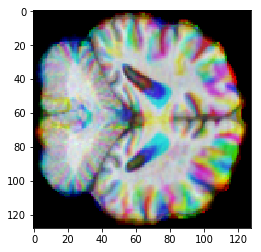

In [895]:
image = data[5]['input']
plt.imshow(normalize(channel_last(image)))

In [874]:
phi(image_to_tensor(image)[np.newaxis])

tensor([[  0.9930,   2.5355,   3.6140,  ...,   1.3776,   0.0000,
           0.0000]], device='cuda:0')

In [875]:
data[pic_no]['attr']

index       1738
AGEreal        1
DX             2
ADAS13         3
FAQ            2
PTRACCAT       6
PTETHCAT       1
PTEDUCAT       1
Name: 19, dtype: object

In [876]:
pic_no = 19
image = data[pic_no]['input']
img_attr = np.array(labels.iloc[pic_no])
print('AGE: {}, dx: {}'.format(img_attr[0], img_attr[1]))
shift = get_shift(
    image, img_attr,
    kneighbors=100,
    source_params=dict(
        #DX=2
        AGEreal=1
    ), 
    target_params=dict(
        #DX=0
        AGEreal=5,
    )
)

AGE: 1, dx: 2


/home/seva100/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [ ]:
shifted_image = inverse(np.array(image).astype(np.float32), 2 * shift, verbose=True)
#shifted_image = (shifted_image - shifted_image.min()) / (np.max(shifted_image) - np.min(shifted_image))
plt.imshow(np.rollaxis(shifted_image, 0, 3))

In [ ]:
shifted_image = inverse_lbfgs(np.array(image).astype(np.float32), 2 * shift, verbose=True, n_iter=20)
#shifted_image = (shifted_image - shifted_image.min()) / (np.max(shifted_image) - np.min(shifted_image))
plt.imshow(channel_last(shifted_image))

In [ ]:
shifted_image = inverse_warp_lbfgs(np.array(image).astype(np.float32), 2 * shift, verbose=True, n_iter=20)
#shifted_image = (shifted_image - shifted_image.min()) / (np.max(shifted_image) - np.min(shifted_image))
plt.imshow(channel_last(shifted_image))

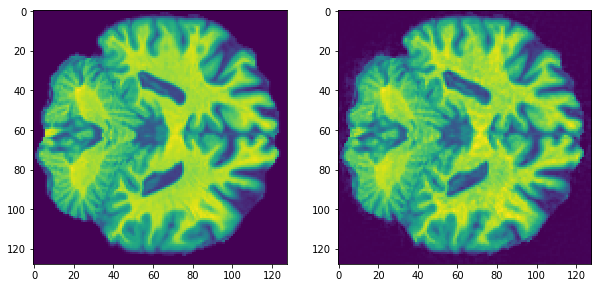

In [845]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(normalize(channel_last(image))[..., 0])
ax[1].imshow(normalize(channel_last(shifted_image))[..., 0])

/home/seva100/miniconda3/lib/python3.6/site-packages/mahotas/internal.py:112: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, np.float):


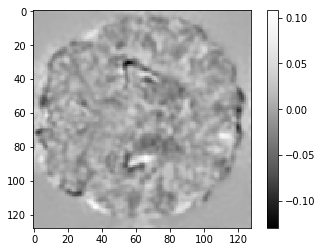

In [846]:
plt.imshow(mh.gaussian_filter(channel_last(shifted_image - image)[..., 1], sigma=1), cmap=plt.cm.Greys_r)
plt.colorbar()

In [847]:
def inverse_improved(image, shift, verbose=False, n_iter=50, beta=0.4):
    alpha = (beta * len(labels.columns)) / np.mean(shift**2)
    return inverse(image, alpha*shift, verbose=verbose, n_iter=n_iter)

def inverse_improved_lbfgs(image, shift, verbose=False, n_iter=50, beta=0.4):
    alpha = (beta * len(labels.columns)) / np.mean(shift**2)
    return inverse_lbfgs(image, alpha*shift, verbose=verbose, n_iter=n_iter)

In [ ]:
improved_shifted_image = normalize(inverse_improved_lbfgs(image, shift, verbose=True, n_iter=50))
plt.imshow(normalize(channel_last(improved_shifted_image)))

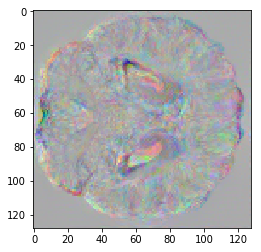

In [854]:
plt.imshow(normalize(channel_last(improved_shifted_image - image)))

##  Applying various transformations (one at a time) to each of several images

Imposing oldest age and the most severe diagnosis.

/home/seva100/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Inference time: 22.90109157562256 s
Inference time: 21.385363817214966 s


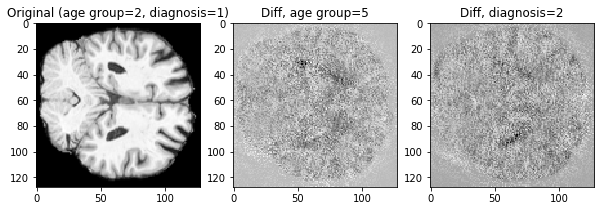

Inference time: 22.508966207504272 s
Inference time: 22.950602293014526 s


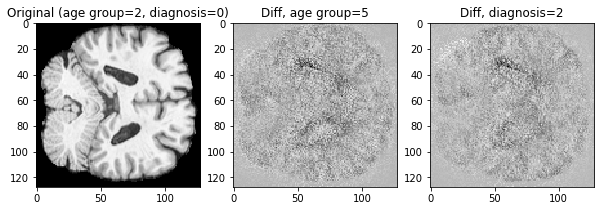

Inference time: 22.914787530899048 s
Inference time: 22.452134132385254 s


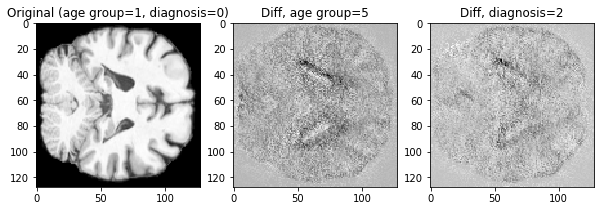

Inference time: 22.22216796875 s
Inference time: 22.852529525756836 s


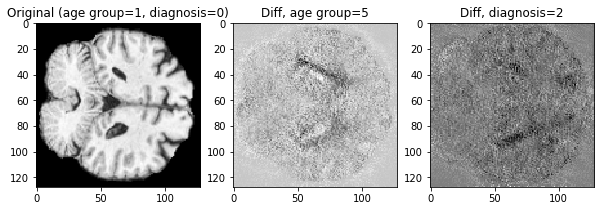

In [754]:
feat_to_show = ['AGEreal', 'DX'] #, 'PTEDUCAT']
feat_names = ['age group', 'diagnosis'] #, 'higher_educ']
feat_vals_to_induce = [5, 2]
#label_inds = np.random.choice(len(filepaths), n_to_show, replace=False)
label_inds = [2, 14, 216, 67]
images = [[] for i in range(len(label_inds))]
shifts = [[] for i in range(len(label_inds))]

for label_idx_no, label_idx in enumerate(label_inds):
    fig, ax = plt.subplots(1, len(feat_to_show) + 1, figsize=(10, 5))
    image = data[label_idx]['input']
    img_attr = labels.iloc[label_idx]
    
    orig_features_strs = ['{}={}'.format(name, val) for name, val in zip(feat_names, img_attr)]
    orig_title = 'Original ({})'.format(', '.join(orig_features_strs))
    ax[0].set_title(orig_title)
    ax[0].imshow(normalize(channel_last(image))[..., 1], cmap=plt.cm.Greys_r)
    for feat_no, feature in enumerate(feat_to_show):
        ax[feat_no + 1].set_title('Diff, {}={}'.format(feat_names[feat_no], feat_vals_to_induce[feat_no]))
        start_time = time()
        shift = get_shift(
            image, np.array(img_attr),
            kneighbors=100,
            source_params={feature: img_attr[feature]}, 
            target_params={feature: feat_vals_to_induce[feat_no]}
        )
        shifted_tensor = inverse_lbfgs(image, 2 * shift, verbose=False, n_iter=20)
        end_time = time()
        print('Inference time:', end_time - start_time, 's')
        
        shifts[label_idx_no].append(shift)
        images[label_idx_no].append(normalize(channel_last(shifted_tensor - image))[..., 1])
        ax[feat_no + 1].imshow(normalize(channel_last(shifted_tensor - image))[..., 1], cmap=plt.cm.Greys_r)
    plt.show()

Interpolating over ADAS13 score.

In [ ]:
feat_to_show = ['ADAS13', 'ADAS13', 'ADAS13', 'ADAS13', 'ADAS13']
feat_names = ['ADAS', 'ADAS', 'ADAS', 'ADAS', 'ADAS']
feat_vals_to_induce = [1, 2, 3, 4, 5]
label_inds = [25, 60, 67]
images = [[] for i in range(len(label_inds))]
shifts = [[] for i in range(len(label_inds))]

for label_idx_no, label_idx in enumerate(label_inds):
    fig, ax = plt.subplots(1, len(feat_to_show) + 1, figsize=(16, 8))
    image = data[label_idx]['input']
    img_attr = labels.iloc[label_idx]
    
    # workaround for this series of plots:
    orig_title = 'Original ({}={})'.format(feat_names[0], labels.loc[label_idx, feat_to_show[0]])
    
    ax[0].set_title(orig_title)
    ax[0].set_axis_off()
    ax[0].imshow(normalize(channel_last(image))[..., 1], cmap=plt.cm.Greys_r)
    for feat_no, feature in enumerate(feat_to_show):
        ax[feat_no + 1].set_title('Diff, {}={}'.format(feat_names[feat_no], feat_vals_to_induce[feat_no]))
        start_time = time()
        shift = get_shift(
            image, np.array(img_attr),
            kneighbors=100,
            source_params={feature: img_attr[feature]}, 
            target_params={feature: feat_vals_to_induce[feat_no]}
        )
        shifted_tensor = inverse_lbfgs(image, 2 * shift, verbose=False, n_iter=20)
        end_time = time()
        print('Inference time:', end_time - start_time, 's')
        
        shifts[label_idx_no].append(shift)
        images[label_idx_no].append(normalize(channel_last(shifted_tensor - image))[..., 1])
        ax[feat_no + 1].set_axis_off()
        ax[feat_no + 1].imshow(normalize(channel_last(shifted_tensor - image))[..., 1], cmap=plt.cm.Greys_r)
    plt.show()

Interpolating over PTEDUCAT education level.

/home/seva100/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Inference time: 25.525025129318237 s
Inference time: 23.15691614151001 s


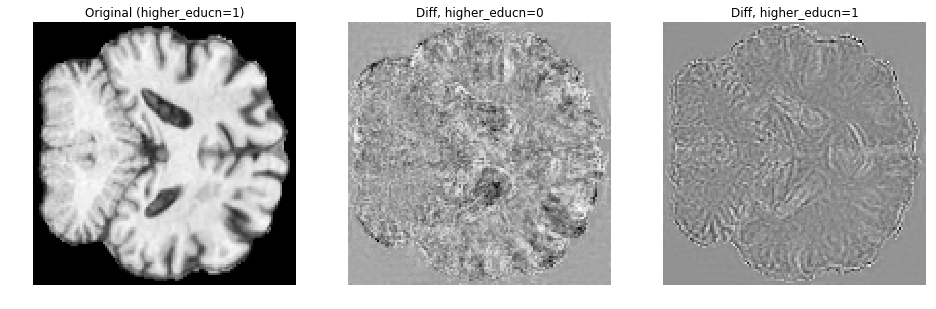

Inference time: 24.789207935333252 s
Inference time: 23.63811182975769 s


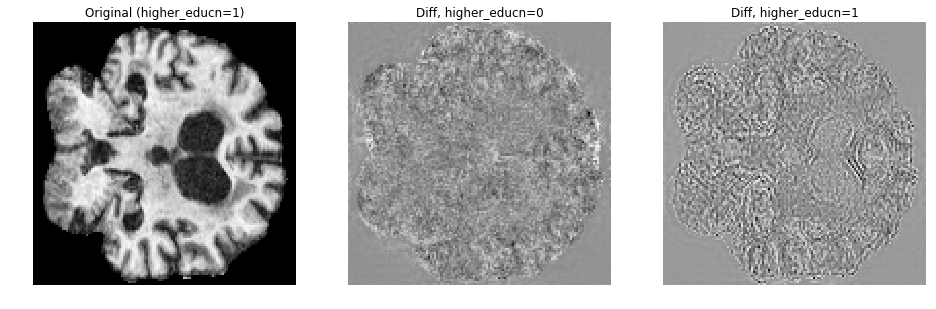

Inference time: 24.06419277191162 s
Inference time: 24.686768531799316 s


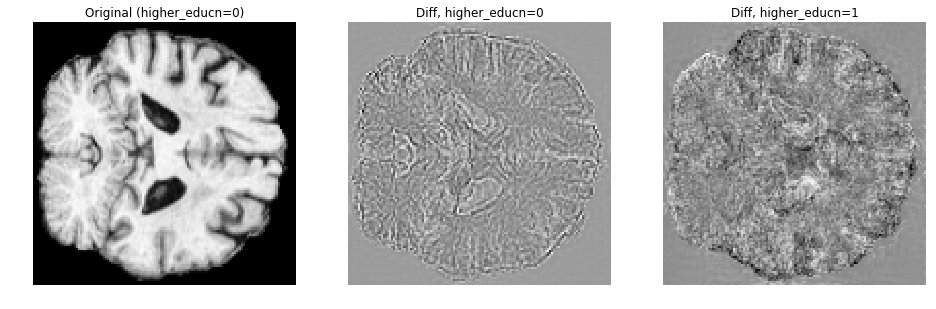

Inference time: 24.284433364868164 s
Inference time: 24.887757778167725 s


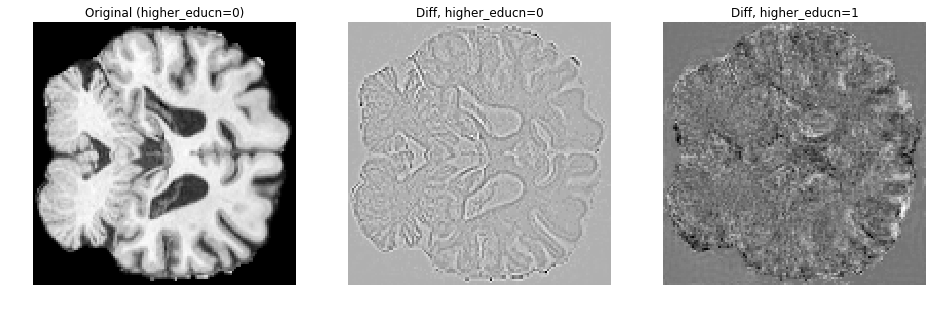

In [869]:
feat_to_show = ['PTEDUCAT', 'PTEDUCAT']
feat_names = ['higher_educn', 'higher_educn']
feat_vals_to_induce = [0, 1]
label_inds = [5, 6, 8, 10]
images = [[] for i in range(len(label_inds))]
shifts = [[] for i in range(len(label_inds))]

for label_idx_no, label_idx in enumerate(label_inds):
    fig, ax = plt.subplots(1, len(feat_to_show) + 1, figsize=(16, 8))
    image = data[label_idx]['input']
    img_attr = labels.iloc[label_idx]
    
    # workaround for this series of plots:
    orig_title = 'Original ({}={})'.format(feat_names[0], labels.loc[label_idx, feat_to_show[0]])
    
    ax[0].set_title(orig_title)
    ax[0].set_axis_off()
    ax[0].imshow(normalize(channel_last(image))[..., 1], cmap=plt.cm.Greys_r)
    for feat_no, feature in enumerate(feat_to_show):
        ax[feat_no + 1].set_title('Diff, {}={}'.format(feat_names[feat_no], feat_vals_to_induce[feat_no]))
        start_time = time()
        shift = get_shift(
            image, np.array(img_attr),
            kneighbors=100,
            source_params={feature: img_attr[feature]}, 
            target_params={feature: feat_vals_to_induce[feat_no]}
        )
        shifted_tensor = inverse_lbfgs(image, 2 * shift, verbose=False, n_iter=20)
        end_time = time()
        print('Inference time:', end_time - start_time, 's')
        
        shifts[label_idx_no].append(shift)
        images[label_idx_no].append(normalize(channel_last(shifted_tensor - image))[..., 1])
        ax[feat_no + 1].set_axis_off()
        ax[feat_no + 1].imshow(normalize(channel_last(shifted_tensor - image))[..., 1], cmap=plt.cm.Greys_r)
    plt.show()

/home/seva100/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


Inference time: 23.75620150566101 s
Inference time: 23.30933380126953 s


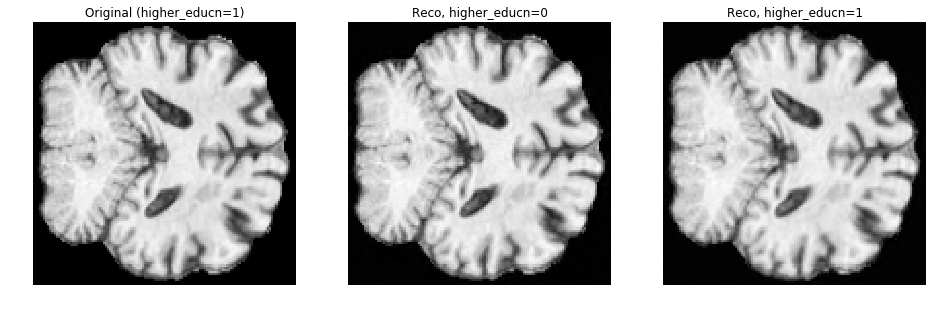

Inference time: 23.780421257019043 s
Inference time: 23.781263828277588 s


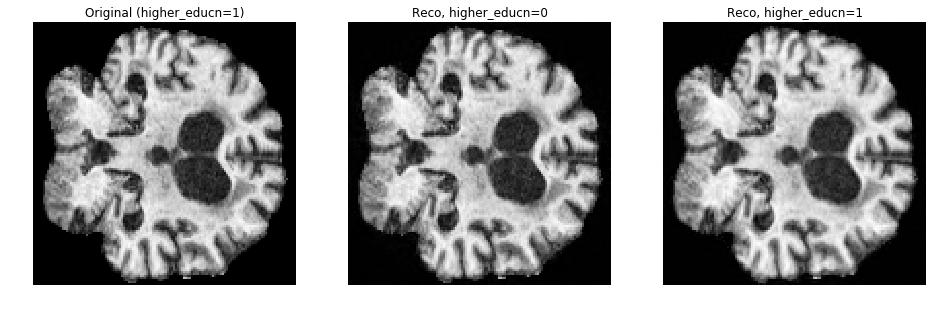

Inference time: 24.14742159843445 s
Inference time: 24.280393838882446 s


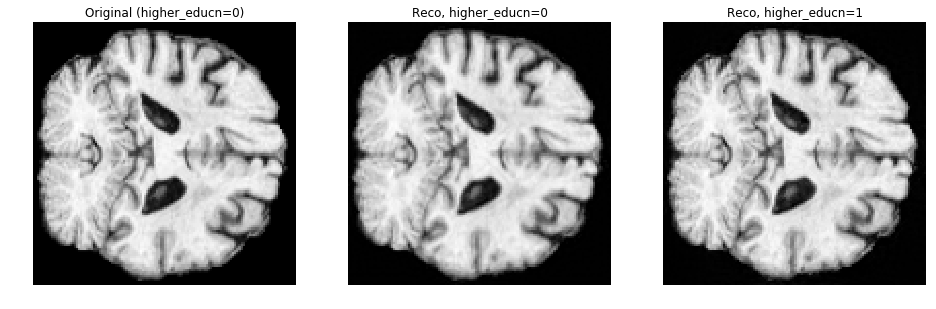

Inference time: 35.350417375564575 s
Inference time: 24.10466194152832 s


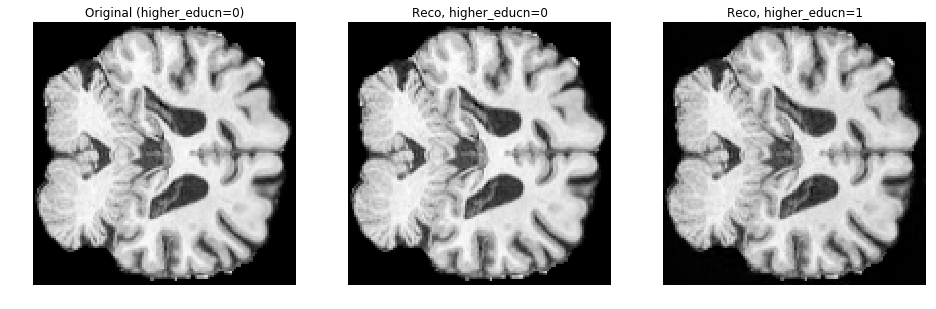

In [870]:
feat_to_show = ['PTEDUCAT', 'PTEDUCAT']
feat_names = ['higher_educn', 'higher_educn']
feat_vals_to_induce = [0, 1]
label_inds = [5, 6, 8, 10]
images = [[] for i in range(len(label_inds))]
shifts = [[] for i in range(len(label_inds))]

for label_idx_no, label_idx in enumerate(label_inds):
    fig, ax = plt.subplots(1, len(feat_to_show) + 1, figsize=(16, 8))
    image = data[label_idx]['input']
    img_attr = labels.iloc[label_idx]
    
    # workaround for this series of plots:
    orig_title = 'Original ({}={})'.format(feat_names[0], labels.loc[label_idx, feat_to_show[0]])
    
    ax[0].set_title(orig_title)
    ax[0].set_axis_off()
    ax[0].imshow(normalize(channel_last(image))[..., 1], cmap=plt.cm.Greys_r)
    for feat_no, feature in enumerate(feat_to_show):
        ax[feat_no + 1].set_title('Reco, {}={}'.format(feat_names[feat_no], feat_vals_to_induce[feat_no]))
        start_time = time()
        shift = get_shift(
            image, np.array(img_attr),
            kneighbors=100,
            source_params={feature: img_attr[feature]}, 
            target_params={feature: feat_vals_to_induce[feat_no]}
        )
        shifted_tensor = inverse_lbfgs(image, 2 * shift, verbose=False, n_iter=20)
        end_time = time()
        print('Inference time:', end_time - start_time, 's')
        
        shifts[label_idx_no].append(shift)
        images[label_idx_no].append(normalize(channel_last(shifted_tensor))[..., 1])
        ax[feat_no + 1].set_axis_off()
        ax[feat_no + 1].imshow(normalize(channel_last(shifted_tensor))[..., 1], cmap=plt.cm.Greys_r)
    plt.show()